In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from surprise import accuracy

In [7]:
products = pd.read_csv('../data/olist_products_dataset.csv')
orders = pd.read_csv("../data/olist_orders_dataset.csv")
items = pd.read_csv("../data/olist_order_items_dataset.csv")
reviews = pd.read_csv("../data/olist_order_reviews_dataset.csv")

# Gabung orders + items + reviews
merged = orders.merge(items, on='order_id')
merged = merged.merge(reviews[['order_id', 'review_score']], on='order_id')

# Ambil kolom yang relevan
df = merged[['customer_id', 'product_id', 'review_score']].dropna()
df = df.drop_duplicates()

df.head()

,customer_id,product_id,review_score
0,9ef432eb6251297304e76186b10a928d,87285b34884572647811a353c7ac498a,4
1,b0830fb4747a6c6d20dea0b8c802d7ef,595fac2a385ac33a80bd5114aec74eb8,4
2,41ce2a54c0b03bf3443c3d931a367089,aa4383b373c6aca5d8797843e5594415,5
3,f88197465ea7920adcdbec7375364d82,d0b61bfb1de832b15ba9d266ca96e5b0,5
4,8ab97904e6daea8866dbdbc4fb7aad2c,65266b2da20d04dbe00c5c2d3bb7859e,5


In [3]:
# Reader surprise butuh rating min dan max
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['customer_id', 'product_id', 'review_score']], reader)

trainset, testset = train_test_split(data, test_size=0.2)

model = SVD()
model.fit(trainset)

# Evaluasi
predictions = model.test(testset)
rmse = accuracy.rmse(predictions)

RMSE: 1.3226


In [4]:
def get_top_n(predictions, n=5):
    from collections import defaultdict
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
    return top_n

top_n = get_top_n(predictions, n=5)

# Lihat hasil rekomendasi user
sample_user = list(top_n.keys())[0]
print(f"Top 5 rekomendasi produk untuk user {sample_user}:\n", top_n[sample_user])

Top 5 rekomendasi produk untuk user 959d2405325e6475dc36c18f9df03248:
 [('f0d56a1df2c0a7a756d7e4352cdcc8f0', 4.060546090953054)]


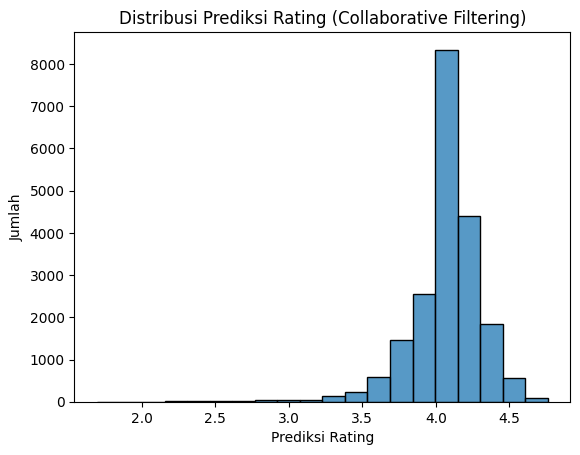

In [5]:
estimates = [pred.est for pred in predictions]
sns.histplot(estimates, bins=20)
plt.title("Distribusi Prediksi Rating (Collaborative Filtering)")
plt.xlabel("Prediksi Rating")
plt.ylabel("Jumlah")
plt.show()

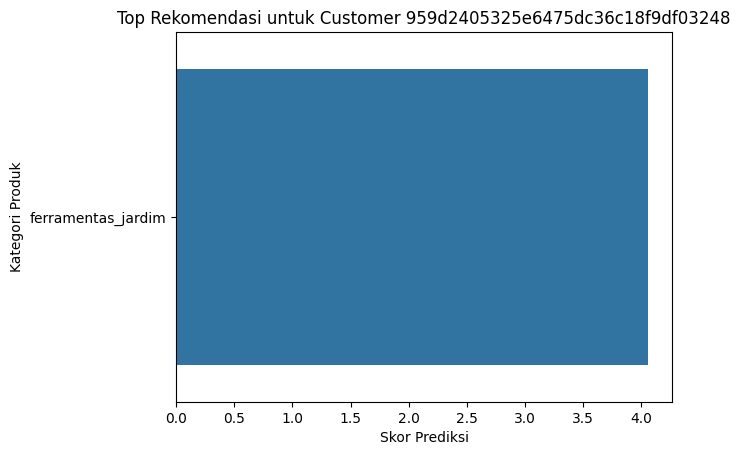

In [8]:
top_n = get_top_n(predictions, n=5)

user_id = list(top_n.keys())[0]
recommended_products = top_n[user_id]

# Gabungkan dengan data produk
rec_df = pd.DataFrame(recommended_products, columns=['product_id', 'estimated_score'])
rec_df = rec_df.merge(products[['product_id', 'product_category_name']], on='product_id', how='left')

sns.barplot(x='estimated_score', y='product_category_name', data=rec_df)
plt.title(f"Top Rekomendasi untuk Customer {user_id}")
plt.xlabel("Skor Prediksi")
plt.ylabel("Kategori Produk")
plt.show()
